In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from IPython import display

from pyDPMP.messagepassing import MaxSumMP, tree_sched
from pyDPMP.mrf import Factor, MRF, calc_potentials
from pyDPMP.particleselection import SelectDiverse
from pyDPMP.proposals import random_walk_proposal, mixture_proposal
from pyDPMP.util import merge_dicts, set_seed
from pyDPMP import DPMP_infer

# %config InlineBackend.figure_format = 'svg'

In [3]:
hinge_pot = lambda x_s: min(0, np.sqrt(np.dot(x_s, x_s)) - 1)
log_barrier_pot = lambda x_s: np.log(np.dot(x_s, x_s) - 1) if np.dot(x_s, x_s) > 1 else -np.inf
def huber_pot(x_s, epsilon):
    d = np.sqrt(np.dot(x_s, x_s)) - 1
    if d < 0:
        return d - epsilon / 2.0
    elif (0 <= d) and (d <= epsilon):
        return -1.0 / (2.0 * epsilon) * ((d - epsilon) ** 2)
    else:
        return 0.0

In [4]:
T = 15
x_start = np.array([0.0, -2.0])
x_goal = np.array([0.0, 2.0])

def deriv_pot(w):
    def pot(*args):
        # Reduce the args by taking finite differences until we get down to a single number.
        # Velocity for two args, acceleration for 3, etc.
        xs = list(args)
        while len(xs) > 1:
            xs = [x_s - x_t for (x_s, x_t) in zip(xs[:-1], xs[1:])]
        x = xs[0]
        return -0.5 * np.dot(x, x) * w
    return pot

obstacle_pots = {
    'obs_{}'.format(t): Factor([t], lambda x_t: huber_pot(x_t, 0.1))
    for t in range(T)
}

def motion_pots(deriv, w):
    pot = deriv_pot(w)
    start_pot = {'motion_d{}_start'.format(deriv): Factor(range(deriv), lambda *args: pot(*((x_start,) + args)))}
    inter_pots = {
        'motion_d{}_t{}'.format(deriv, t): Factor(list(t + np.arange(deriv + 1)), pot)
        for t in range(T - deriv)
    }
    goal_pot = {'motion_d{}_goal'.format(deriv): Factor(range(T - deriv, T), lambda *args: pot(*(args + (x_goal,))))}
    return merge_dicts(start_pot, inter_pots, goal_pot)

mrf = MRF(range(T), merge_dicts(
    obstacle_pots,
    motion_pots(1, 1.0)))

In [5]:
maxsum = MaxSumMP(mrf, sched=tree_sched(mrf, 0))

In [6]:
def uniform_proposal(mrf, nAdd, x):
    return {v: np.random.rand(nAdd[v], 2) * 4 - 2 for v in mrf.nodes}

def midpoint_proposal(mrf, nAdd, x):
    x_prop = {t: [] for t in range(T)}
    for t in range(1, T - 1):
        x_prop[t] = [0.5 * (random.choice(x[t - 1]) + random.choice(x[t + 1]))
                     for _ in range(nAdd[t])]
    return x_prop

def flip_proposal(mrf, nAdd, x):
    return {t: [random.choice(x[t]) * np.array([-1, 1]) for _ in range(nAdd[t])]
            for t in range(T)}

rw_proposal = random_walk_proposal(1e-2 * np.eye(2))

In [7]:
x0 = {t: [(1 - float(t)/T) * x_start + (float(t)/T) * x_goal] for t in mrf.nodes}
# x0 = {t: [(1 - float(t)/T) * x_start + (float(t)/T) * x_goal + np.array([1,0])] for t in mrf.nodes}

In [8]:
nParticles = 10

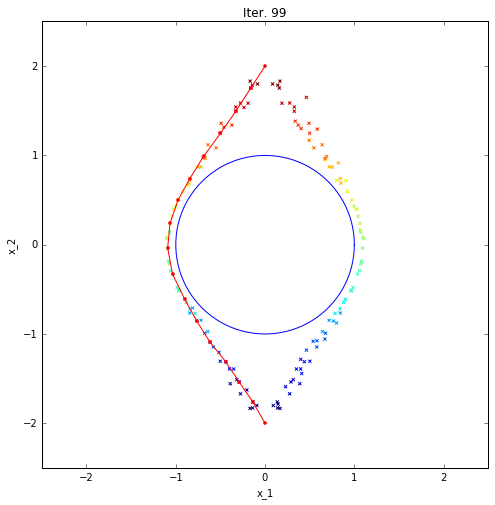

In [9]:
%matplotlib inline

set_seed(1)

plt.figure(figsize=(8, 8))
def callback(info):
    x = info['x']
    xMAP = info['xMAP']

    plt.clf()
    plt.axis([-2.5, 2.5, -2.5, 2.5])
    an = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))
    particles = [x_t for t in range(T) for x_t in x[t]]
    c = [float(t) / float(T) for t in range(T) for x_t in x[t]]
#     plt.scatter(*zip(*particles), s=10, c='r', marker='x')
    plt.scatter(*zip(*particles), s=10, c=c, marker='x')

    MAPparticles = [x_start] + [xMAP[t] for t in range(T)] + [x_goal]
    plt.plot(*zip(*MAPparticles), c='r', marker='.')

    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.title('Iter. %d' % info['iter'])

    display.clear_output(wait=True)
    display.display(plt.gcf())
#     time.sleep(0.25)

xMAP, xParticles, stats = DPMP_infer(mrf,
                                     x0,
                                     nParticles,
                                     mixture_proposal([uniform_proposal,
                                                       rw_proposal,
                                                       midpoint_proposal,
                                                       flip_proposal],
                                                      weights=[0.0, 0.5, 0.0, 0.5]),
                                     SelectDiverse(),
                                     maxsum,
                                     conv_tol=None,
                                     max_iters=100,
                                     callback=callback,
                                     verbose=True)

display.clear_output(wait=True)

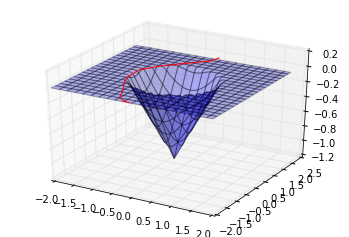

In [11]:
%matplotlib qt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

fig = plt.figure(1)
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)

X = np.arange(-2, 2, 0.05)
Y = np.arange(-2, 2, 0.05)
x_mesh, y_mesh = np.meshgrid(X, Y)
Z = np.array([[huber_pot([x, y], 0.1) for x in X] for y in Y])
ax.plot_surface(x_mesh, y_mesh, Z, rstride=4, cstride=4, alpha=0.3)

x_path, y_path = zip(*[xMAP[t] for t in range(T)])
z_path = [huber_pot(xMAP[t], 0.1) for t in range(T)]
ax.plot(x_path, y_path, z_path, c='r')

In [12]:
%matplotlib qt

import matplotlib.animation as animation

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))
ax.grid()

an = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(an), np.sin(an))

line, = ax.plot([], [], 'o-', lw=2)

def anim_init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x, y = xMAP[i][0], xMAP[i][1]

    line.set_data([x], [y])
    return (line,)

ani = animation.FuncAnimation(fig, animate, range(T),
    interval=25, blit=False, init_func=anim_init)

ani.save('basic_plan.mp4', fps=25)